<a href="https://colab.research.google.com/github/zszazi/awesome-collection-of-google-colab-notebooks/blob/master/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**WORD2VEC**


> By - [zszazi](https://github.com/zszazi)



In [0]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tfv

In [0]:
#DATA

data_url = 'http://mattmahoney.net/dc/text8.zip'

In [0]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [0]:
words = fetch_words_data()

In [0]:
len(words)

17005207

Thats 17 million words!!!!!

In [0]:
# Random slice of words (some 50 words)
words[4400:4450]

In [0]:
for w in words[4400:4450]:
    print(w,end=' ')
#puctuations are also removed    

eco anarchists or green anarchists believe in deep ecology this is a worldview that embraces biodiversity and sustainability eco anarchists often use direct action against what they see as earth destroying institutions of particular importance is the earth first movement that takes action such as tree sitting another important component 

**Build Word Counts**


In [0]:
from collections import Counter

In [0]:
def create_counts(vocab_size=50000):

    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    
    # Turn it into a numpy array
    vocab = np.array([word for word, _ in vocab])
    
    
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab

In [0]:
vocab_size = 50000

In [0]:
data,vocabulary = create_counts(vocab_size=vocab_size)

**Function for Batches**

from TF docs

In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [0]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [0]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right 
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2        

In [0]:
""" We pick a random validation set to sample nearest neighbors. Here we limit the
 validation samples to the words that have a low numeric ID, which by
 construction are also the most frequent.""""

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

**TF placeholders and variables**

In [0]:
import tensorflow as tf
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [0]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

**using Noise Contrastive Estimation (NCE) loss **

In [0]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [0]:
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

**Optimizer ADAM**

In [0]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


In [0]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Add variable initializer.
init = tf.global_variables_initializer()

**TF Sesssion**

In [0]:
# for GPU 
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [0]:
num_steps = 200001

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

       

    final_embeddings = normalized_embeddings.eval()

#VISUALIZE RESULT

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

In [0]:
type(final_embeddings)

numpy.ndarray

In [0]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [0]:
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

In [0]:
labels = [vocabulary[i] for i in range(plot_only)]

In [0]:
low_dim_embs.shape

(2000, 2)

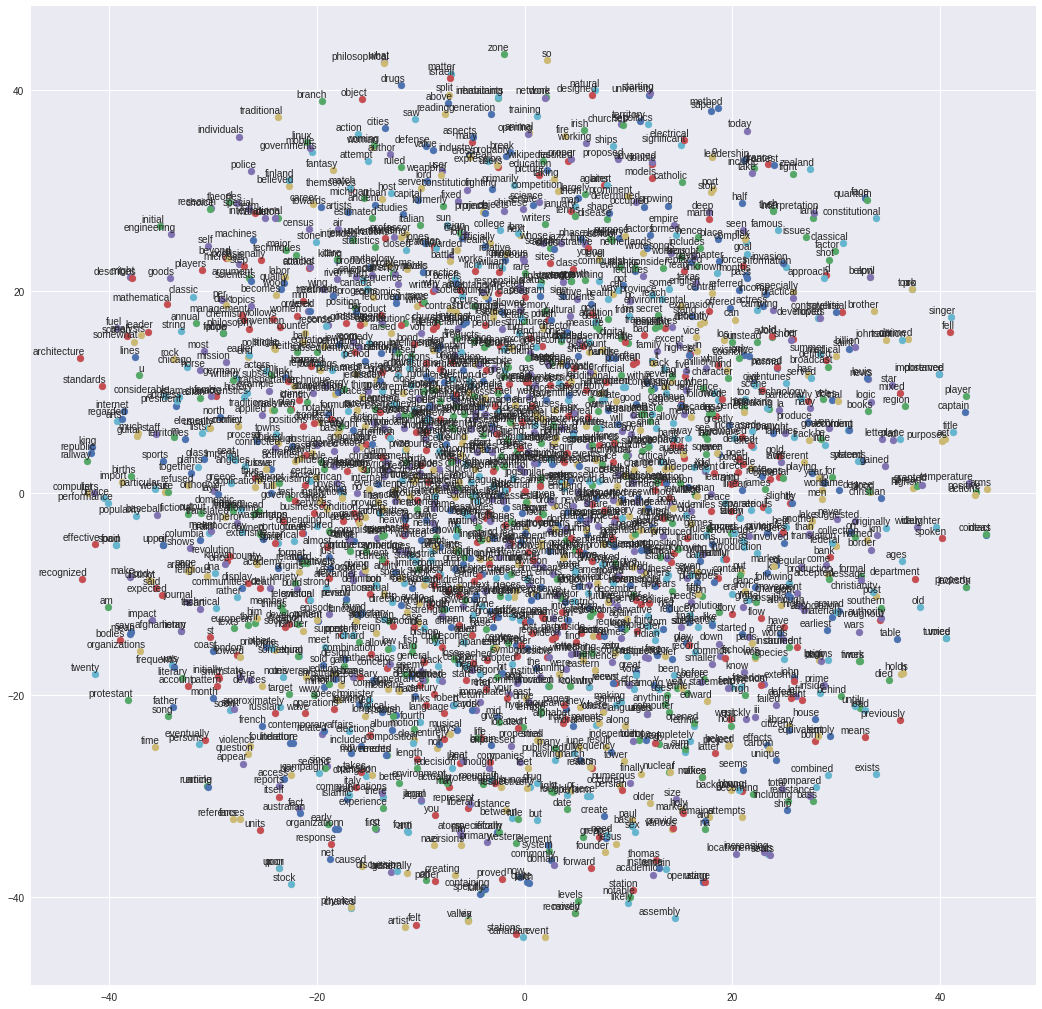

In [0]:
plot_with_labels(low_dim_embs, labels)